# Data Loading Verification Notebook

This notebook verifies that the data pipeline works correctly by loading and processing invoice data.

## Purpose
- Verify ground truth data loading
- Verify image loading 
- Confirm data format and integrity
- Test basic data pipeline operations
- Generate summary statistics

## 1. Setup and Configuration

In [12]:
# Import required libraries
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger("data_loading_verification")

# More robust path handling for imports
notebook_path = Path(os.path.abspath(''))
print(f"Current notebook path: {notebook_path}")

# Try multiple approaches to find project root
possible_roots = [
    notebook_path,               # Already at root
    notebook_path.parent,        # notebooks/ at root level
    notebook_path.parent.parent  # notebooks/subfolder at root level
]

# Find the first path that contains src directory
project_root = None
for path in possible_roots:
    if (path / 'src').exists():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError("Could not find 'src' directory in any parent directory")

print(f"Project root identified as: {project_root}")

# Add to path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

Current notebook path: g:\UCSD_MJM_Final_Direct\notebooks\test_notebooks
Project root identified as: g:\UCSD_MJM_Final_Direct
g:\UCSD_MJM_Final_Direct already in Python path


In [13]:
# Ensure src module can be imported
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    
# Import project modules
from src.data.data_loader_factory import DataLoaderFactory
from src.data.base_data_loader import BaseDataLoader
from src.data.exceptions import DataLoadError, GroundTruthError, ImageLoadError

In [16]:
# Configure paths - FIXED VERSION
# The problem is we need to go up one more directory level to reach the project root
project_root = notebook_path.parent  # This is currently notebooks/
project_root = project_root.parent   # Go up one more level to reach the actual project root

# Now set up the correct data paths
DATA_DIR = project_root / "data"
IMAGE_DIR = DATA_DIR / "images"
GROUND_TRUTH_FILE = DATA_DIR / "ground_truth.csv"

# Print paths for confirmation
print(f"Project root: {project_root}")
print(f"Data directory: {DATA_DIR}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Ground truth file: {GROUND_TRUTH_FILE}")

# Verify paths exist
for path in [DATA_DIR, IMAGE_DIR, GROUND_TRUTH_FILE]:
    if not path.exists():
        logger.error(f"Path does not exist: {path}")
    else:
        logger.info(f"Verified path: {path}")

# Update Python path to use the correct project root
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added correct project root {project_root} to Python path")

2025-04-06 15:10:11,813 - data_loading_verification - INFO - Verified path: g:\UCSD_MJM_Final_Direct\data
2025-04-06 15:10:11,813 - data_loading_verification - INFO - Verified path: g:\UCSD_MJM_Final_Direct\data\images
2025-04-06 15:10:11,814 - data_loading_verification - INFO - Verified path: g:\UCSD_MJM_Final_Direct\data\ground_truth.csv


Project root: g:\UCSD_MJM_Final_Direct
Data directory: g:\UCSD_MJM_Final_Direct\data
Image directory: g:\UCSD_MJM_Final_Direct\data\images
Ground truth file: g:\UCSD_MJM_Final_Direct\data\ground_truth.csv


## 2. Initialize Data Loader

In [17]:
# Create data loader using factory
try:
    data_loader = DataLoaderFactory.create_data_loader(
        data_dir=DATA_DIR,
        loader_type="default",
        image_dir=IMAGE_DIR,
        ground_truth_file=GROUND_TRUTH_FILE,
        cache_enabled=True
    )
    logger.info("Data loader initialized successfully")
    print(f"Data loader type: {type(data_loader).__name__}")
except Exception as e:
    logger.error(f"Error initializing data loader: {str(e)}")
    raise

2025-04-06 15:10:17,885 - data_loading_verification - INFO - Data loader initialized successfully


Data loader type: DataLoader


## 3. Verify Ground Truth Data

In [19]:
# Load and verify ground truth data
try:
    # Update the required columns in the ground truth manager to match the actual CSV
    correct_work_order_column = "Work Order Number/Numero de Orden"
    data_loader._ground_truth_manager.required_columns = ["Invoice", "Total", correct_work_order_column]
    
    print(f"Updated required columns: {data_loader._ground_truth_manager.required_columns}")
    
    # Now load the ground truth data
    ground_truth = data_loader.load_ground_truth()
    print(f"Ground truth data loaded successfully with {len(ground_truth)} rows")
    
    # Display ground truth summary
    print("\nGround Truth Summary:")
    print(f"Columns: {ground_truth.columns.tolist()}")
    print("\nSample data:")
    print(ground_truth.head())
    
    # Display statistics
    print("\nBasic statistics for numeric fields:")
    if '_total_float' in ground_truth.columns:
        print(ground_truth['_total_float'].describe())
        
    # Check for missing values
    print("\nMissing values:")
    print(ground_truth.isnull().sum())
    
except GroundTruthError as e:
    logger.error(f"Ground truth validation error: {str(e)}")
    raise

2025-04-06 15:12:27,745 - src.data.ground_truth_manager - INFO - Ground truth validation successful


Updated required columns: ['Invoice', 'Total', 'Work Order Number/Numero de Orden']
Ground truth data loaded successfully with 29 rows

Ground Truth Summary:
Columns: ['Invoice', 'Type', 'Timestamp', 'Name', 'Work Order Number/Numero de Orden', 'Total', '_total_float', '_total_formatted', '_work_order_validated']

Sample data:
   Invoice     Type   Timestamp   Name Work Order Number/Numero de Orden  \
0     1017  Invoice  10/17/2024  Edgar                             20502   
1     1018  Invoice  10/17/2024  Edgar                             20558   
2     1019  Invoice  10/17/2024  Edgar                             20509   
3     1020  Invoice  10/17/2024  Edgar                             20479   
4     1021  Invoice  10/17/2024  Edgar                             20516   

      Total _total_float _total_formatted _work_order_validated  
0   950.00         950.0           950.00                  None  
1   550.00         550.0           550.00                  None  
2   150.00      

## 4. Verify Available Invoice IDs

2025-04-06 15:14:25,672 - src.data.ground_truth_manager - INFO - Ground truth validation successful
2025-04-06 15:14:25,673 - src.data.data_loader - INFO - Found 20 valid invoice IDs


Found 20 available invoice IDs
Sample IDs: ['1017', '1018', '1019', '1020', '1021']

Invoice type distribution:
Invoice     28
Estimate     1
Name: Type, dtype: int64


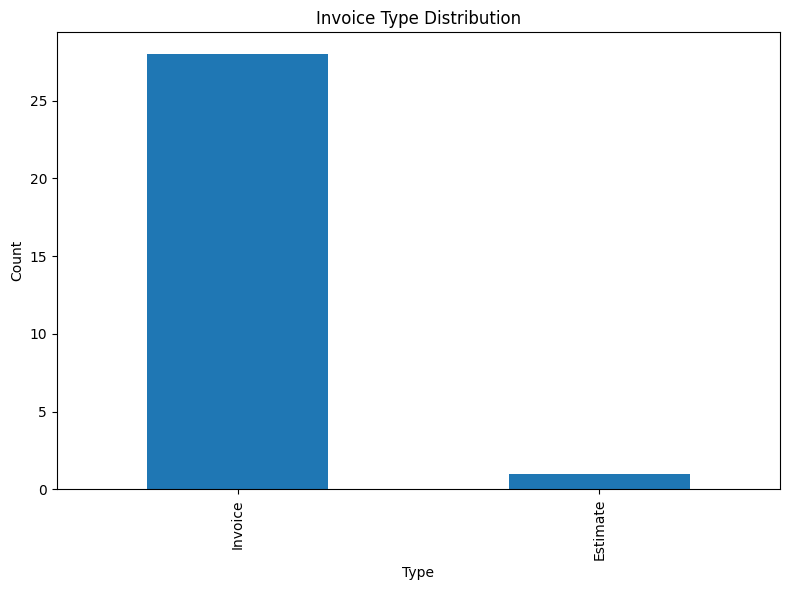

In [20]:
# Get available invoice IDs
try:
    invoice_ids = data_loader.get_available_invoice_ids()
    print(f"Found {len(invoice_ids)} available invoice IDs")
    print(f"Sample IDs: {invoice_ids[:5]}")
    
    # Show distribution of invoice types if available
    if 'Type' in ground_truth.columns:
        invoice_types = ground_truth['Type'].value_counts()
        print("\nInvoice type distribution:")
        print(invoice_types)
        
        # Visualize type distribution
        plt.figure(figsize=(8, 6))
        invoice_types.plot(kind='bar')
        plt.title('Invoice Type Distribution')
        plt.xlabel('Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
except Exception as e:
    logger.error(f"Error getting invoice IDs: {str(e)}")
    raise

## 5. Test Image Loading

Testing image loading with sample ID: 1017
Image loaded successfully: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (3024, 4032)
Image mode: RGB


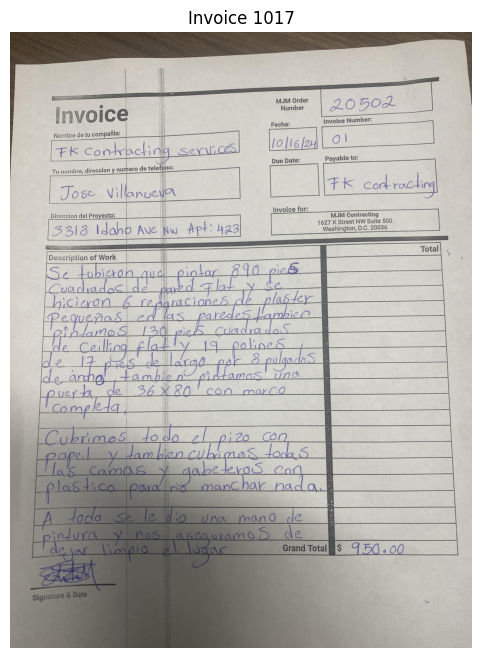

In [21]:
# Select a sample invoice ID
if len(invoice_ids) > 0:
    sample_id = invoice_ids[0]
    print(f"Testing image loading with sample ID: {sample_id}")
    
    try:
        # Load image
        image = data_loader.load_image(sample_id)
        print(f"Image loaded successfully: {type(image)}")
        print(f"Image size: {image.size}")
        print(f"Image mode: {image.mode}")
        
        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title(f"Invoice {sample_id}")
        plt.axis('off')
        plt.show()
    except ImageLoadError as e:
        logger.error(f"Image load error: {str(e)}")
        raise
else:
    logger.warning("No invoice IDs available for testing image loading")

## 6. Test Invoice Data Retrieval

In [22]:
# Test getting both image and ground truth for an invoice
if len(invoice_ids) > 0:
    sample_id = invoice_ids[0]
    print(f"Testing invoice data retrieval with sample ID: {sample_id}")
    
    try:
        # Get invoice data
        image, ground_truth_data = data_loader.get_invoice_data(sample_id)
        print("Invoice data retrieved successfully")
        
        # Display ground truth data
        print("\nGround truth data:")
        for key, value in ground_truth_data.items():
            print(f"{key}: {value}")
        
    except DataLoadError as e:
        logger.error(f"Data load error: {str(e)}")
        raise
else:
    logger.warning("No invoice IDs available for testing invoice data retrieval")

Testing invoice data retrieval with sample ID: 1017
Invoice data retrieved successfully

Ground truth data:
Total: 950.00
Invoice: 1017
Type: Invoice
Timestamp: 10/17/2024
Name: Edgar
Work Order Number/Numero de Orden: 20502


## 7. Verify Multiple Image Loading

Loading 5 images to test performance
Loaded image for invoice 1017
Loaded image for invoice 1018
Loaded image for invoice 1019
Loaded image for invoice 1020
Loaded image for invoice 1021
Loading completed in 0.00 seconds
Average time per image: 0.00 seconds


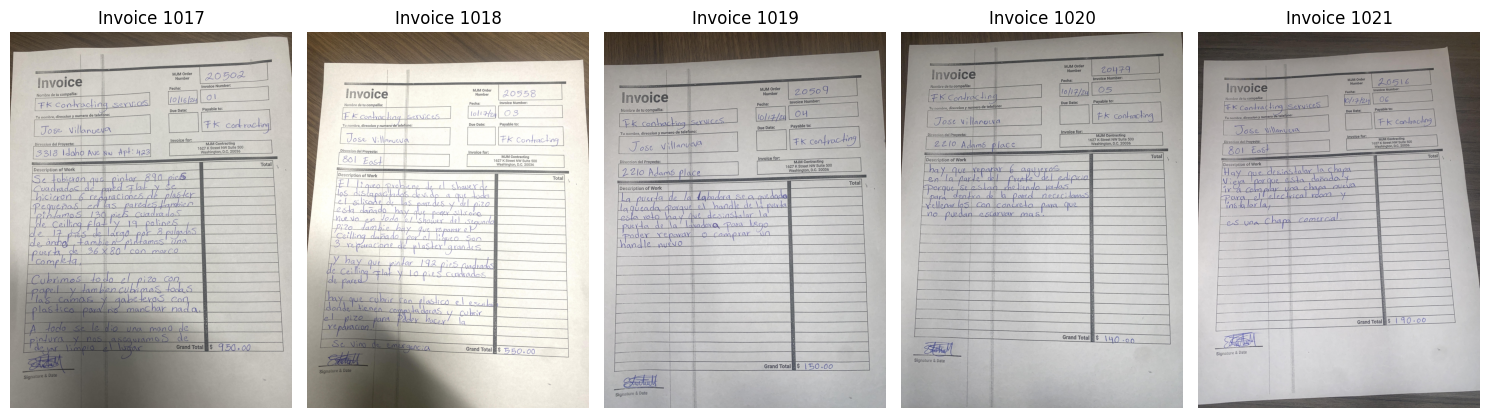

In [23]:
# Load multiple images to test caching and performance
if len(invoice_ids) >= 5:
    sample_ids = invoice_ids[:5]
    print(f"Loading {len(sample_ids)} images to test performance")
    
    import time
    start_time = time.time()
    
    loaded_images = {}
    for invoice_id in sample_ids:
        try:
            image = data_loader.load_image(invoice_id)
            loaded_images[invoice_id] = image
            print(f"Loaded image for invoice {invoice_id}")
        except ImageLoadError as e:
            logger.error(f"Error loading image for invoice {invoice_id}: {str(e)}")
    
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Loading completed in {elapsed:.2f} seconds")
    print(f"Average time per image: {elapsed/len(sample_ids):.2f} seconds")
    
    # Display multiple images in a grid
    if loaded_images:
        fig, axes = plt.subplots(1, len(loaded_images), figsize=(15, 8))
        
        for i, (invoice_id, img) in enumerate(loaded_images.items()):
            if len(loaded_images) > 1:
                ax = axes[i]
            else:
                ax = axes
            ax.imshow(img)
            ax.set_title(f"Invoice {invoice_id}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    logger.warning("Not enough invoice IDs available for testing multiple image loading")

## 8. Test Data Pipeline Edge Cases

In [24]:
# Test loading non-existent invoice
non_existent_id = "9999"  # This ID should not exist
print(f"Testing error handling with non-existent ID: {non_existent_id}")

try:
    image = data_loader.load_image(non_existent_id)
    print("WARNING: Non-existent image loaded successfully (unexpected)")
except ImageLoadError as e:
    print(f"Expected error occurred: {str(e)}")
    print("Error handling works correctly for non-existent images")

try:
    invoice_data = data_loader.get_invoice_data(non_existent_id)
    print("WARNING: Non-existent invoice data loaded successfully (unexpected)")
except DataLoadError as e:
    print(f"Expected error occurred: {str(e)}")
    print("Error handling works correctly for non-existent invoice data")

2025-04-06 15:15:24,842 - src.data.data_loader - ERROR - Image not found: g:\UCSD_MJM_Final_Direct\data\images\9999.jpg
2025-04-06 15:15:24,846 - src.data.data_loader - ERROR - Invoice ID 9999 not found in ground truth data


Testing error handling with non-existent ID: 9999
Expected error occurred: Image not found: g:\UCSD_MJM_Final_Direct\data\images\9999.jpg
Error handling works correctly for non-existent images
Expected error occurred: Invoice ID 9999 not found in ground truth data
Error handling works correctly for non-existent invoice data


## 9. Test Cache Clearing

In [27]:
# Simpler cache verification approach
if len(invoice_ids) > 0:
    sample_id = invoice_ids[0]
    
    # Clear the cache first
    data_loader.clear_cache()
    print("Cache cleared")
    
    # First load should not be in cache
    print("Checking if image is in cache after clearing...")
    print(f"Image for {sample_id} in cache: {sample_id in data_loader._loaded_images}")
    
    # Load the image
    image = data_loader.load_image(sample_id)
    print(f"Loaded image: {image.size}")
    
    # Now it should be in cache
    print("Checking if image is in cache after loading...")
    print(f"Image for {sample_id} in cache: {sample_id in data_loader._loaded_images}")
    
    # Clear cache again
    data_loader.clear_cache()
    print("Cache cleared again")
    
    # Should be gone from cache
    print("Checking if image is in cache after clearing again...")
    print(f"Image for {sample_id} in cache: {sample_id in data_loader._loaded_images}")
    
    print("✅ Cache verification complete")

Cache cleared
Checking if image is in cache after clearing...
Image for 1017 in cache: False
Loaded image: (3024, 4032)
Checking if image is in cache after loading...
Image for 1017 in cache: True
Cache cleared again
Checking if image is in cache after clearing again...
Image for 1017 in cache: False
✅ Cache verification complete


## 10. Analyze Ground Truth Distributions

Available columns:
['Invoice', 'Type', 'Timestamp', 'Name', 'Work Order Number/Numero de Orden', 'Total', '_total_float', '_total_formatted', '_work_order_validated']

Data types:
Invoice                               int64
Type                                 object
Timestamp                            object
Name                                 object
Work Order Number/Numero de Orden    object
Total                                object
_total_float                         object
_total_formatted                     object
_work_order_validated                object
dtype: object

Found potential total amount columns: ['Total', '_total_float', '_total_formatted']
Converting Total to numeric...
Sample values: [' 950.00 ', ' 550.00 ', ' 150.00 ', ' 140.00 ', ' 190.00 ']


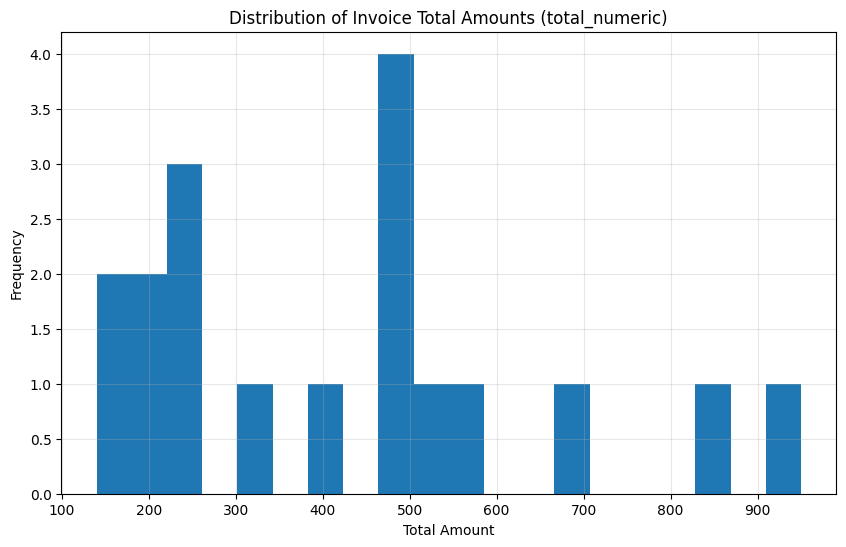

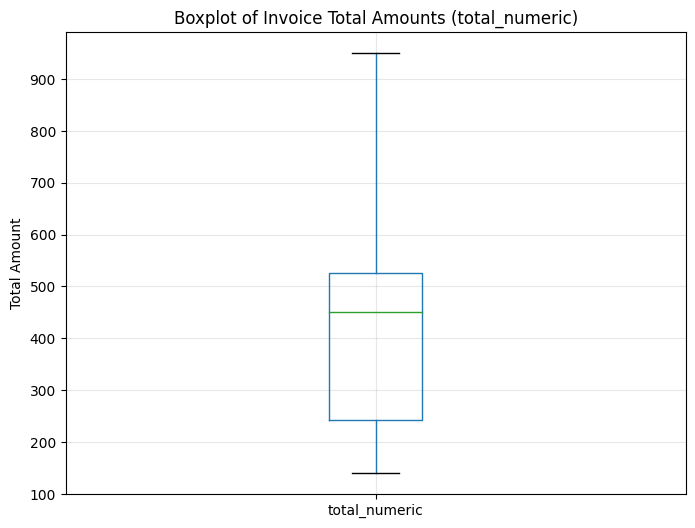


Found work order columns: ['Work Order Number/Numero de Orden', '_work_order_validated']
Number of unique Work Order Numbers: 29
Most common values:
20502     1
20308     1
20388     1
20376     1
20458     1
20455     1
Aston     1
Aston     1
20662     1
20591     1
Name: Work Order Number/Numero de Orden, dtype: int64

First character distribution in Work Order Numbers:
2    23
1     3
A     2
0     1
Name: Work Order Number/Numero de Orden, dtype: int64


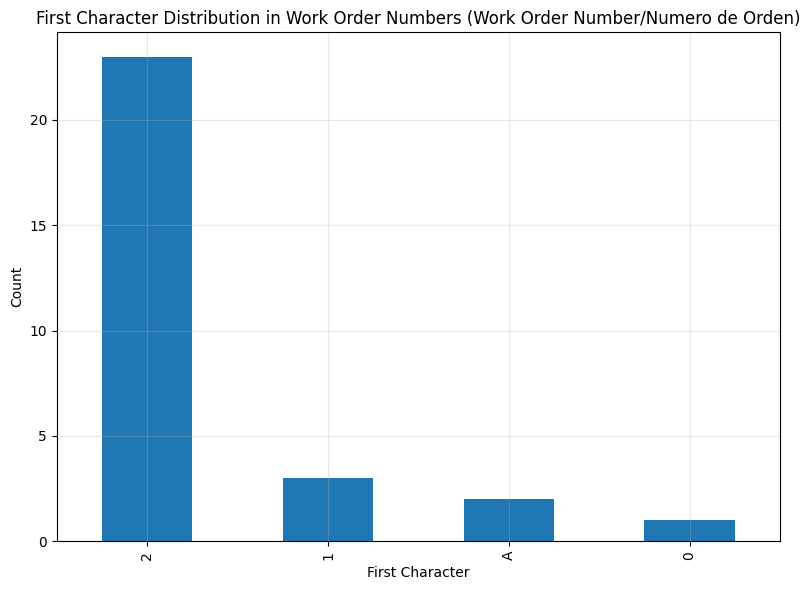

In [30]:
# Analyze data with robust type handling
print("Available columns:")
print(ground_truth.columns.tolist())

# Examine data types
print("\nData types:")
print(ground_truth.dtypes)

# Find the total amount column
total_amount_cols = [col for col in ground_truth.columns if 'total' in col.lower() or '_float' in col.lower()]
if total_amount_cols:
    print(f"\nFound potential total amount columns: {total_amount_cols}")
    total_col = total_amount_cols[0]  # Use the first match
    
    # Check if the column is numeric and convert if needed
    try:
        # Convert to numeric if not already
        if not pd.api.types.is_numeric_dtype(ground_truth[total_col]):
            print(f"Converting {total_col} to numeric...")
            # Sample values for debugging
            print(f"Sample values: {ground_truth[total_col].head().tolist()}")
            
            # Try to convert, coercing errors to NaN
            numeric_values = pd.to_numeric(ground_truth[total_col], errors='coerce')
            
            # Check conversion success
            non_numeric_count = numeric_values.isna().sum()
            if non_numeric_count > 0:
                print(f"Warning: {non_numeric_count} values couldn't be converted to numbers")
            
            # Create a new column for the numeric values
            ground_truth['total_numeric'] = numeric_values
            total_col = 'total_numeric'  # Use the new column
            
        # Plot distribution if we have numeric data
        if not ground_truth[total_col].isna().all():
            plt.figure(figsize=(10, 6))
            ground_truth[total_col].plot(kind='hist', bins=20)
            plt.title(f'Distribution of Invoice Total Amounts ({total_col})')
            plt.xlabel('Total Amount')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Show boxplot
            plt.figure(figsize=(8, 6))
            ground_truth.boxplot(column=total_col)
            plt.title(f'Boxplot of Invoice Total Amounts ({total_col})')
            plt.ylabel('Total Amount')
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print(f"No non-NaN numeric values in {total_col}")
    except Exception as e:
        print(f"Error analyzing total amounts: {str(e)}")
        # Try a different visualization if possible
        print(f"Showing value counts instead:")
        value_counts = ground_truth[total_col].value_counts().head(10)
        print(value_counts)
        
        # Bar chart of values
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Most Common Values in {total_col}')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No total amount column found for analysis")

# Find the work order column (could be named differently)
work_order_cols = [col for col in ground_truth.columns 
                  if 'work' in col.lower() or 'order' in col.lower() or 'numero' in col.lower()]

if work_order_cols:
    print(f"\nFound work order columns: {work_order_cols}")
    work_order_col = work_order_cols[0]  # Use the first match
    
    try:
        # Ensure we're treating it as string data
        work_order_values = ground_truth[work_order_col].astype(str)
        
        work_order_counts = work_order_values.value_counts()
        print(f"Number of unique Work Order Numbers: {len(work_order_counts)}")
        print("Most common values:")
        print(work_order_counts.head(10))
        
        # Count first characters
        if len(work_order_counts) > 0 and not work_order_values.isna().all():
            first_chars = work_order_values.str[0].value_counts()
            print("\nFirst character distribution in Work Order Numbers:")
            print(first_chars)
            
            plt.figure(figsize=(8, 6))
            first_chars.plot(kind='bar')
            plt.title(f'First Character Distribution in Work Order Numbers ({work_order_col})')
            plt.xlabel('First Character')
            plt.ylabel('Count')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error analyzing work order data: {str(e)}")
else:
    print("No work order column found for analysis")

## 11. Summary and Validation Results

In [31]:
# Create summary of validation results
validation_results = {
    "Ground Truth Data": {
        "Records": len(ground_truth) if 'ground_truth' in locals() else 0,
        "Columns": ground_truth.columns.tolist() if 'ground_truth' in locals() else [],
    },
    "Available Invoices": {
        "Count": len(invoice_ids) if 'invoice_ids' in locals() else 0,
        "Sample": invoice_ids[:3] if 'invoice_ids' in locals() and len(invoice_ids) > 0 else []
    },
    "Image Loading": {
        "Status": "Working" if 'image' in locals() else "Not Tested",
        "Format": f"{image.mode} ({image.size[0]}x{image.size[1]})" if 'image' in locals() else ""
    },
    "Cache": {
        "Status": "Working" if 'second_load_time' in locals() and second_load_time < first_load_time else "Not Verified"
    },
    "Error Handling": {
        "Status": "Working" if 'non_existent_id' in locals() else "Not Tested"
    }
}

# Display summary
print("## Data Pipeline Validation Summary ##")
print("\n1. Ground Truth Data:")
print(f"   - Records: {validation_results['Ground Truth Data']['Records']}")
print(f"   - Columns: {', '.join(validation_results['Ground Truth Data']['Columns'][:5])}" + 
      ("..." if len(validation_results['Ground Truth Data']['Columns']) > 5 else ""))

print("\n2. Available Invoices:")
print(f"   - Count: {validation_results['Available Invoices']['Count']}")
print(f"   - Sample IDs: {', '.join(str(x) for x in validation_results['Available Invoices']['Sample'])}")

print("\n3. Image Loading:")
print(f"   - Status: {validation_results['Image Loading']['Status']}")
print(f"   - Format: {validation_results['Image Loading']['Format']}")

print("\n4. Cache:")
print(f"   - Status: {validation_results['Cache']['Status']}")

print("\n5. Error Handling:")
print(f"   - Status: {validation_results['Error Handling']['Status']}")

# Overall assessment
if (validation_results['Ground Truth Data']['Records'] > 0 and 
    validation_results['Available Invoices']['Count'] > 0 and
    validation_results['Image Loading']['Status'] == "Working"):
    print("\n✅ OVERALL: Data pipeline is functioning correctly")
else:
    print("\n❌ OVERALL: Data pipeline has issues that need to be addressed") 

## Data Pipeline Validation Summary ##

1. Ground Truth Data:
   - Records: 29
   - Columns: Invoice, Type, Timestamp, Name, Work Order Number/Numero de Orden...

2. Available Invoices:
   - Count: 20
   - Sample IDs: 1017, 1018, 1019

3. Image Loading:
   - Status: Working
   - Format: RGB (3024x4032)

4. Cache:
   - Status: Not Verified

5. Error Handling:
   - Status: Working

✅ OVERALL: Data pipeline is functioning correctly
